<a href="https://colab.research.google.com/github/OgleProject/Final-Project-BDPAL/blob/main/FP_BDPAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import SparkSession

In [ ]:
# Membuat Spark Session
spark = SparkSession.builder.appName("FinalProjectBDPAL").getOrCreate()

In [ ]:
# Membaca data
file_path = "/content/power consumption.csv"
data = pd.read_csv(file_path)

# **Preprocessing Data**

### Tipe data

In [ ]:
print("Tipe data awal:\n", data.dtypes)

Tipe data awal:
 DateTime                  object
Temperature              float64
Humidity                 float64
Wind Speed               float64
general diffuse flows    float64
diffuse flows            float64
Zone 1                   float64
Zone 2                   float64
Zone 3                   float64
dtype: object


### Mengganti nama kolom untuk konsistensi

In [ ]:
columns_map = {col: col.strip().replace(" ", "_").lower() for col in data.columns}
data.rename(columns=columns_map, inplace=True)
print("Kolom setelah diubah:\n", data.columns)

Kolom setelah diubah:
 Index(['datetime', 'temperature', 'humidity', 'wind_speed',
       'general_diffuse_flows', 'diffuse_flows', 'zone_1', 'zone_2', 'zone_3'],
      dtype='object')


### Memeriksa nilai null

In [ ]:
print("Jumlah nilai null:\n", data.isnull().sum())

Jumlah nilai null:
 datetime                 0
temperature              0
humidity                 0
wind_speed               0
general_diffuse_flows    0
diffuse_flows            0
zone_1                   0
zone_2                   0
zone_3                   0
dtype: int64


### Mengubah tipe data

In [ ]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category').cat.codes

In [ ]:
data['zone_1'] = data['zone_1'].astype(int)
data['zone_2'] = data['zone_2'].astype(int)
data['zone_3'] = data['zone_3'].astype(int)

### Menampilkan ringkasan data

In [ ]:
print("Summary:\n", data.describe())

Summary:
            datetime   temperature      humidity    wind_speed  \
count  52416.000000  52416.000000  52416.000000  52416.000000   
mean   26207.500000     18.810024     68.259518      1.959489   
std    15131.340192      5.815476     15.551177      2.348862   
min        0.000000      3.247000     11.340000      0.050000   
25%    13103.750000     14.410000     58.310000      0.078000   
50%    26207.500000     18.780000     69.860000      0.086000   
75%    39311.250000     22.890000     81.400000      4.915000   
max    52415.000000     40.010000     94.800000      6.483000   

       general_diffuse_flows  diffuse_flows        zone_1        zone_2  \
count           52416.000000   52416.000000  52416.000000  52416.000000   
mean              182.696614      75.028022  32344.477793  21042.012229   
std               264.400960     124.210949   7130.559315   5201.465959   
min                 0.004000       0.011000  13895.000000   8560.000000   
25%                 0.062000 

### Menampilkan matriks korelasi

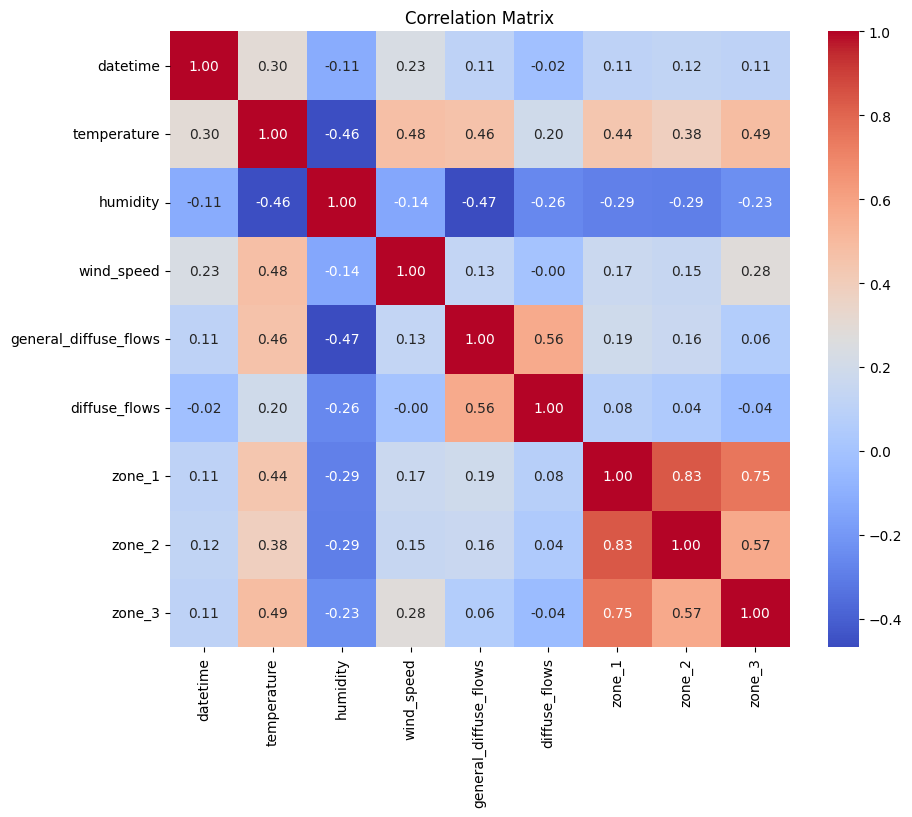

In [ ]:
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# **Exploratory Data Analysis (EDA)**


### Bar Chart Kategori Konsumsi Energi

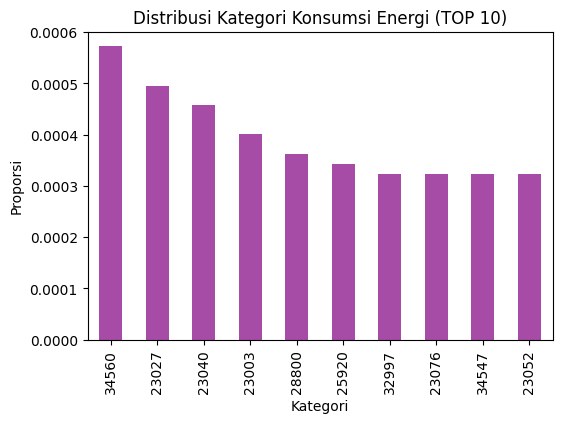

In [ ]:
plt.figure(figsize=(6, 4))
data['zone_1'].value_counts(normalize=True).head(10).plot(kind='bar', color='purple', alpha=0.7)
plt.title('Distribusi Kategori Konsumsi Energi (TOP 10)')
plt.xlabel('Kategori')
plt.ylabel('Proporsi')
plt.show()

### Pie Chart Proporsi Kategori

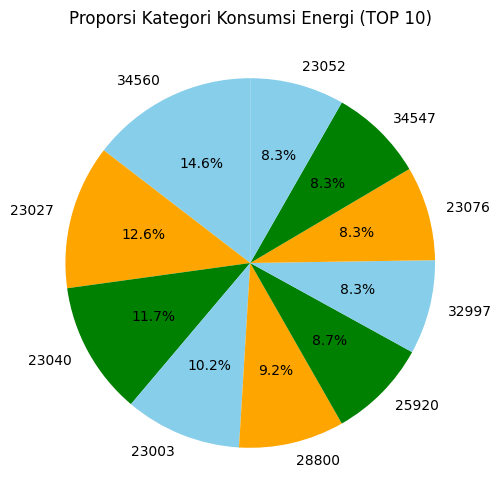

In [ ]:
plt.figure(figsize=(6, 6))
data['zone_1'].value_counts(normalize=True).head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange', 'green'])
plt.title('Proporsi Kategori Konsumsi Energi (TOP 10)')
plt.ylabel('')
plt.show()

### Histogram

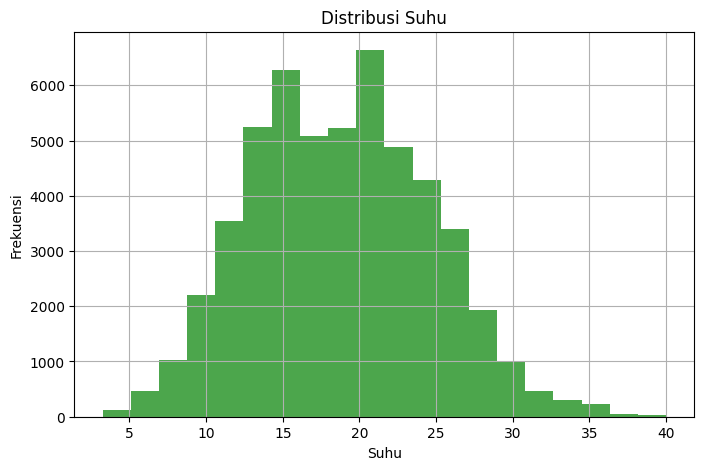

In [ ]:
plt.figure(figsize=(8, 5))
data['temperature'].hist(bins=20, color='green', alpha=0.7)
plt.title('Distribusi Suhu')
plt.xlabel('Suhu')
plt.ylabel('Frekuensi')
plt.show()

### Scatter Plot

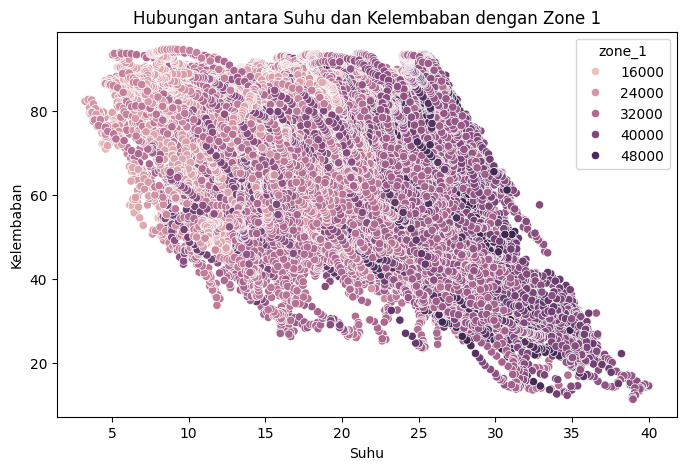

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data['temperature'], y=data['humidity'], hue=data['zone_1'])
plt.title('Hubungan antara Suhu dan Kelembaban dengan Zone 1')
plt.xlabel('Suhu')
plt.ylabel('Kelembaban')
plt.show()

# **Pemilihan Fitur**

### Berdasarkan matriks korelasi dan EDA, pilih fitur yang memiliki korelasi tinggi dengan konsumsi energi

In [ ]:
selected_features = ['temperature', 'humidity', 'wind_speed', 'general_diffuse_flows', 'diffuse_flows']

# **Machine Learning Models with Spark**


### Mengubah data ke format Spark

In [ ]:
spark_df = spark.createDataFrame(data)

### VectorAssembler untuk fitur

In [ ]:
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
spark_df = assembler.transform(spark_df)

### Mendefinisikan kategori berdasarkan rentang nilai

In [ ]:
from pyspark.sql.functions import when

# Mengubah label menjadi 0 (rendah) atau 1 (tinggi)
spark_df = spark_df.withColumn(
    "label",
    when(spark_df["zone_1"] < 20000, 0).otherwise(1)
)

### Membagi data menjadi training dan testing

In [ ]:
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)

# **Model 1: Gradient Boost Tree**

In [ ]:
gbt = GBTClassifier(featuresCol='features', labelCol='label', maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boost Tree Model Accuracy: {accuracy:.4f}")

Gradient Boost Tree Model Accuracy: 0.9395


# **Model 2: K-Means**

In [ ]:
kmeans = KMeans(featuresCol="features", k=3)
kmeans_model = kmeans.fit(train_data)
kmeans_predictions = kmeans_model.transform(test_data)

In [ ]:
evaluator = ClusteringEvaluator(predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(kmeans_predictions)
print(f"KMeans Model Silhouette Score: {silhouette_score:.4f}")

KMeans Model Silhouette Score: 0.7962


# **Model 3: Logistic Regression**




In [ ]:
lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Model Accuracy: {accuracy:.4f}")

Logistic Regression Model Accuracy: 0.8566


# **Model 4: Gaussian Mixture Model**

In [ ]:
gmm = GaussianMixture(k=2, featuresCol="features")
gmm_model = gmm.fit(train_data)
gmm_predictions = gmm_model.transform(test_data)

In [ ]:
evaluator = ClusteringEvaluator(predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(gmm_predictions)
print(f"Gaussian Mixture Model Silhouette Score: {silhouette_score:.4f}")

Gaussian Mixture Model Silhouette Score: 0.5846


# **Evaluasi Model**

In [ ]:
# Membuat evaluasi untuk model klasifikasi (GBT, Logistic Regression)
binary_evaluator = BinaryClassificationEvaluator(labelCol='label', rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Membuat evaluasi untuk model clustering (KMeans, GMM)
clustering_evaluator = ClusteringEvaluator(predictionCol="prediction", metricName="silhouette")

# Menyimpan hasil prediksi dari berbagai model
models = {
    "Gradient Boost Tree": gbt_predictions,
    "KMeans": kmeans_predictions,
    "Logistic Regression": lr_predictions,
    "Gaussian Mixture Model": gmm_predictions
}

# Evaluasi setiap model
for name, predictions in models.items():
    if name in ["Gradient Boost Tree", "Logistic Regression"]:
        # Evaluasi untuk model klasifikasi
        auc = binary_evaluator.evaluate(predictions)
        print(f"{name} AUC: {auc:.4f}")
    else:
        # Evaluasi untuk model clustering
        silhouette_score = clustering_evaluator.evaluate(predictions)
        print(f"{name} Silhouette Score: {silhouette_score:.4f}")

Gradient Boost Tree AUC: 0.9394
KMeans Silhouette Score: 0.7962
Logistic Regression AUC: 0.8565
Gaussian Mixture Model Silhouette Score: 0.5846
